In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import (Input, Convolution2D, ZeroPadding2D, 
                          MaxPooling2D, Flatten, Dense, Dropout, Activation)
from keras.models import model_from_json, Model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import load_img, save_img, img_to_array
from matplotlib.ticker import PercentFormatter
from PIL import Image
from sklearn import metrics

In [14]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [15]:
#you can download the pretrained weights from the following link 
#https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#or you can find the detailed documentation https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('./vgg_face_weights.h5')

In [16]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [17]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def findNormalisedEuclideanDistance(x, y):
    var_x = np.var(x)
    var_y = np.var(y)
    var_xy = np.var(x-y)
    dist = 0.5 * var_xy / (var_x + var_y)
    return dist

In [18]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [19]:
def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image(img1))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image(img2))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    norm_euclidean_distance = findNormalisedEuclideanDistance(img1_representation, img2_representation)
    '''
    epsilon = 0.20
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")
    '''
    return cosine_similarity, euclidean_distance, norm_euclidean_distance


In [36]:
def getDistancesSamePerson():

    dists = []
    path = './images/Alloutput/'
    for filePath in sorted(os.listdir(path)):
        sketchPath = os.path.join(path, filePath)
        imgPath = os.path.join(os.path.dirname(os.path.dirname(path)), 'Alltarget/', filePath)
        dists.append(verifyFace(sketchPath, imgPath))
    return dists


def getDistancesDiffPerson():

    dists = []
    pathSketches = './images/Alloutput/'
    pathImages = './images/Alltarget/'
    for skeName in sorted(os.listdir(pathSketches)):
        for imgName in sorted(os.listdir(pathImages)):
            if(skeName==imgName):
                continue

            sketchPath = os.path.join(pathSketches, skeName)
            imgPath = os.path.join(pathImages, imgName)
            dists.append(verifyFace(sketchPath, imgPath))
    return dists

def saveImagesRepresentations():

    representations = [] #(rep, imaName)
    
    pathImages = './images/Alltarget/'
    #pathImages = './images/photos_resized/'
    for imgName in sorted(os.listdir(pathImages)):
        #print('I')
        imgPath = os.path.join(pathImages, imgName)
        imgRepresentation = vgg_face_descriptor.predict(preprocess_image(imgPath))[0,:]
        representations.append((imgName,imgRepresentation))
    pickle.dump(representations,open('imgRepresentations.pickle' , 'wb'))


def getDistancesAndLabels():

    dists = []
    labels = [] #0 if diff, 1 if equal
    pathSketches = './images/Alloutput/'
    pathImages = './images/Alltarget/'
    for skeName in sorted(os.listdir(pathSketches)):
        for imgName in sorted(os.listdir(pathImages)):
            if(skeName==imgName):
                labels.append(1)
            else:
                labels.append(0)

            sketchPath = os.path.join(pathSketches, skeName)
            imgPath = os.path.join(pathImages, imgName)
            dists.append(verifyFace(sketchPath, imgPath))
    return dists, labels


def delsaveRepresentations():

    dists = []
    labels = [] #0 if diff, 1 if equal
    
    pathSketches = './images/Alloutput/'
    pathImages = './images/Alltarget/'
    for skeName in sorted(os.listdir(pathSketches)):
        print(skeName)
        
#saveImagesRepresentations()

In [21]:
def displayMinMaxDists(dists):
    mins = list(map(min, zip(*dists))) 
    maxs = list(map(max, zip(*dists))) 
    
    print ("The min and max of Cosine similarity :  " +  str((mins[0],maxs[0]))) 
    print ("The min and max of Euclidean distance :  " +  str((mins[1],maxs[1]))) 
    print ("The min and max of Norm Euclidean distance :  " +  str((mins[2],maxs[2])))

    
def displayHistograms(dists, bins=30):
    cosSims = [i[0] for i in dists]
    eucDists = [i[1] for i in dists]
    normEucDists = [i[2] for i in dists]
    
    '''
    plt.title('Cosine Sim')
    plt.plot([i[0] for i in dists],'*',color=[0.5,0.5,0.5])
    plt.show()
    
    plt.title('Cosine Similarity')
    plt.plot(cosSims, np.zeros_like(cosSims), 'x')
    plt.yticks([])
    plt.show()
    
    plt.title('Cosine Similarity')   
    plt.hist(cosSims, density=True, bins=30) # density
    plt.ylabel('Probability');
    plt.show()   
    '''
    
    plt.title('Cosine Similarity')  
    plt.hist(cosSims, weights=np.ones(len(cosSims)) / len(cosSims), bins=bins)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

    plt.title('Euclidean Distance') 
    plt.hist(eucDists, weights=np.ones(len(eucDists)) / len(eucDists), bins=bins)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()
    
    plt.title('Normalised Euclidean Distance')
    plt.hist(normEucDists, weights=np.ones(len(normEucDists)) / len(normEucDists), bins=bins)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()
    
    return
    
    
    
def displayThresholdPercentages(dists, samePerson=False, cosSimThreshold = .16, 
                       eucDistThreshold = 70, normEucDistThreshold = .09):
    
    cosSims = [i[0] for i in dists]
    eucDists = [i[1] for i in dists]
    normEucDists = [i[2] for i in dists]
    
    cosSimsBelowThreshold = sum(i < cosSimThreshold for i in cosSims)/len(dists)
    eucDistsBelowThreshold = sum(i < eucDistThreshold for i in eucDists)/len(dists)
    normEucDistsBelowThreshold = sum(i < normEucDistThreshold for i in normEucDists)/len(dists)
    
    if(samePerson):
        print(f'Elems with Cosine similarity lower than {cosSimThreshold}: {cosSimsBelowThreshold}')
        print(f'Elems with Euclidean distance lower than {eucDistThreshold}: {eucDistsBelowThreshold}')
        print(f'Elems with Normalised Euclidean Distance lower than {normEucDistThreshold}: {normEucDistsBelowThreshold}')
    else:
        print(f'Elems with Cosine similarity higher than {cosSimThreshold}: {1- cosSimsBelowThreshold}')
        print(f'Elems with Euclidean distance higher than {eucDistThreshold}: {1- eucDistsBelowThreshold}')
        print(f'Elems with Normalised Euclidean Distance higher than {normEucDistThreshold}: {1- normEucDistsBelowThreshold}')
    
    return
        

def displayROCCurves(scores, labels):
    cosSims = [i[0] for i in scores]
    eucDists = [i[1] for i in scores]
    normEucDists = [i[2] for i in scores]

    fprCos, tprCos, thresholdsCos = metrics.roc_curve(labels, cosSims)
    rocAucCos = metrics.auc(1-fprCos, 1-tprCos)

    fprEuc, tprEuc, thresholdsEuc = metrics.roc_curve(labels, eucDists)
    rocAucEuc = metrics.auc(1-fprEuc, 1-tprEuc)

    fprNormEuc, tprNormEuc, thresholdsNormEuc = metrics.roc_curve(labels, normEucDists)
    rocAucNormEuc = metrics.auc(1-fprNormEuc, 1-tprNormEuc)

    plt.figure()
    lw = 2
    plt.plot(1-fprCos, 1-tprCos, color='darkorange',
         lw=lw, label='ROC curve Cos (area = %0.2f)' % rocAucCos)
    plt.plot(1-fprEuc, 1-tprEuc, color='blue',
         lw=lw, label='ROC curve Euc (area = %0.2f)' % rocAucEuc)
    plt.plot(1-fprNormEuc, 1-tprNormEuc, color='green',
         lw=lw, label='ROC curve NormEuc (area = %0.2f)' % rocAucNormEuc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return    

The min and max of Cosine similarity :  (0.05702096223831177, 0.2092074751853943)
The min and max of Euclidean distance :  (36.384827, 90.513985)
The min and max of Norm Euclidean distance :  (0.02974714007186342, 0.10579415861383469)


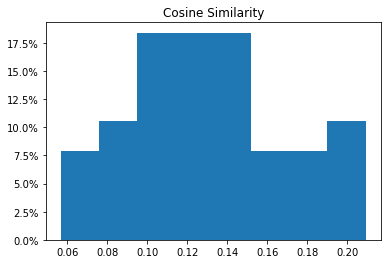

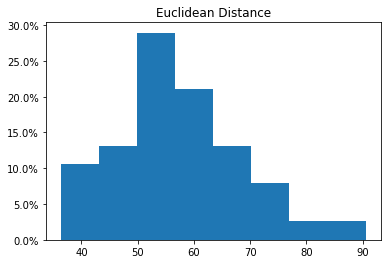

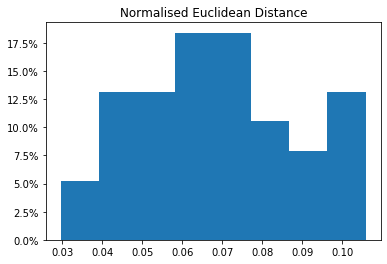

Elems with Cosine similarity lower than 0.16: 0.7631578947368421
Elems with Euclidean distance lower than 70: 0.868421052631579
Elems with Normalised Euclidean Distance lower than 0.09: 0.8157894736842105


In [7]:
#distsSamePerson = getDistancesSamePerson()
distsSamePerson = pickle.load(open('samePerson.pickle','rb'))

displayMinMaxDists(distsSamePerson)

displayHistograms(distsSamePerson, bins = 8)

displayThresholdPercentages(distsSamePerson, samePerson=True)


#pickle.dump(distsSamePerson,open('samePerson.pickle' , 'wb'))

The min and max of Cosine similarity :  (0.09586530923843384, 0.7605726718902588)
The min and max of Euclidean distance :  (45.27294, 171.805)
The min and max of Norm Euclidean distance :  (0.0508690457048847, 0.38706563402574146)


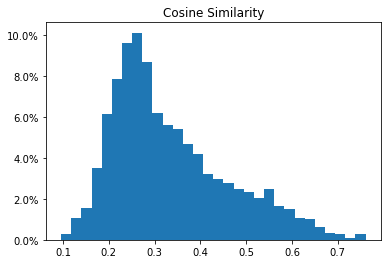

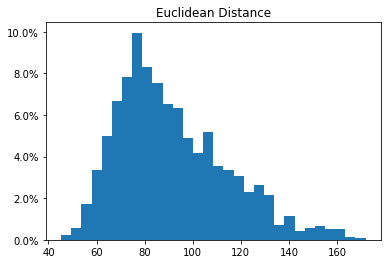

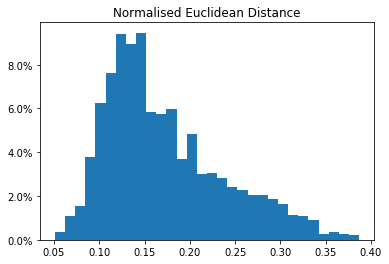

Elems with Cosine similarity higher than 0.16: 0.9743954480796586
Elems with Euclidean distance higher than 70: 0.8364153627311522
Elems with Normalised Euclidean Distance higher than 0.09: 0.957325746799431


In [8]:
#distsDiffPerson = getDistancesDiffPerson()
distsDiffPerson = pickle.load(open('diffPerson.pickle','rb'))

displayMinMaxDists(distsDiffPerson)

displayHistograms(distsDiffPerson)

displayThresholdPercentages(distsDiffPerson)

#pickle.dump(distsDiffPerson,open('diffPerson.pickle' , 'wb'))


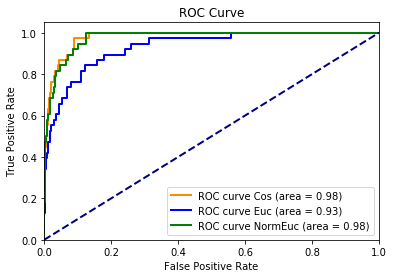

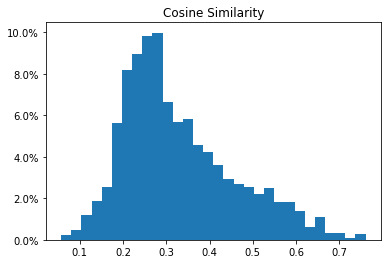

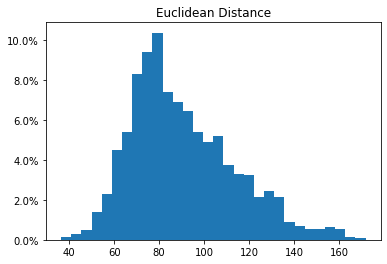

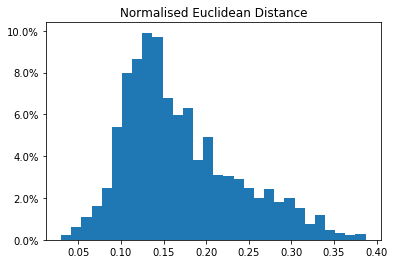

In [9]:
#scores, labels = getDistancesAndLabels()
scores, labels  = pickle.load(open('all.pickle','rb'))

displayROCCurves(scores, labels)
displayHistograms(scores)

#pickle.dump((scores,labels),open('all.pickle' , 'wb'))

In [40]:
'''
pathImage = './images/Alloutput/m-026-tr.png'
imgRep = vgg_face_descriptor.predict(preprocess_image(pathImage))[0,:]
findCosineSimilarity(imgRep, imgRep)
print(imgRep.shape)
'''



def findMostSimilar(skePath,numSimilar):
    imgRep = vgg_face_descriptor.predict(preprocess_image(skePath))[0,:]
    reps  = pickle.load(open('imgRepresentations.pickle','rb'))
    #print(reps[0][0])
    #print(reps[0][1].shape)
    #findNormalisedEuclideanDistance(skeRep, skeRep)
    #[findCosineSimilarity(skeRep, i[1]) for i in scores]
    #findEuclideanDistance
    
    sims = [(i[0],findNormalisedEuclideanDistance(imgRep, i[1])) for i in reps]
    sims.sort(key=lambda tup: tup[1])
    #print(sims[:numSimilar])
    return sims[:numSimilar]
             
#findMostSimilar(pathImage,2)


In [46]:
'''
counter = 0 
pathSketches = './images/Alloutput/'
for skeName in sorted(os.listdir(pathSketches)):
    sketchPath = os.path.join(pathSketches, skeName)
    mostSimilar = findMostSimilar(sketchPath)
    print(mostSimilar[0],skeName)
    if(mostSimilar[0]==skeName):
       counter+=1
print(counter)
print(len(os.listdir(pathSketches)))
'''
def correctIdentification(numTries):
    counter = 0
    pathSketches = './images/images/'
    for skeName in sorted(os.listdir(pathSketches)):
        sketchPath = os.path.join(pathSketches, skeName)
        mostSimilar = findMostSimilar(sketchPath,numTries)
        imgNames = [i[0] for i in mostSimilar]
        #print(mostSimilar[0],skeName)
        #if any(x in paid[j] for x in d):
        #if(mostSimilar[0]==skeName):
        if skeName in imgNames:
           counter+=1
        else:
            print(skeName)
        
        
    return print(f'Number of tries {numTries}: {counter/len(os.listdir(pathSketches))}')



correctIdentification(1)
'''
correctIdentification(2)
correctIdentification(3)
correctIdentification(4)
correctIdentification(5)
correctIdentification(6)
correctIdentification(7)
'''




f-021-tr.png
m-017-tr.png
m-018-tr.png
m-022-te.png
m-028-tr.png
m-035-te.png
m-040-tr.png
m-064-te.png
m-067-te.png
m-084-te.png
m-086-te.png
Number of tries 1: 0.7105263157894737


'\ncorrectIdentification(2)\ncorrectIdentification(3)\ncorrectIdentification(4)\ncorrectIdentification(5)\ncorrectIdentification(6)\ncorrectIdentification(7)\n'

In [50]:
skePath='/home/gildt/Desktop/f-021-tr.png'
skePath = './images/images/f-021-tr.png'
findMostSimilar(skePath,1)

[('f-001-te.png', 0.06721550416476496)]